In [ ]:
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipImageProcessor, BlipForQuestionAnswering
from transformers import AutoProcessor
from datasets import load_dataset
import requests
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
data = load_dataset('flaviagiammarino/vqa-rad')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

Question: what type of image is this?
Answer: x-ray


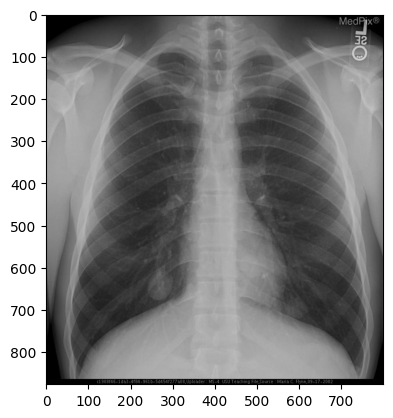

In [ ]:
import matplotlib.pyplot as plt
sample = data['train'][78]
print('Question:', sample['question'])
print('Answer:', sample['answer'])
plt.imshow(sample['image'].convert('RGB'))

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = BlipProcessor.from_pretrained('Salesforce/blip-vqa-base')
model = BlipForQuestionAnswering.from_pretrained('Salesforce/blip-vqa-base')

print(f'GPU counts: {torch.cuda.device_count()}')
model.to(device)

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

GPU counts: 1


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [ ]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']

        image = self.dataset[idx]['image'].convert('RGB')
        text = question

        encoding = self.processor(
            image, text, padding='max_length', truncation=True, return_tensors='pt'
        )

        labels = self.processor.tokenizer.encode(
            answer, padding='max_length', truncation=True, return_tensors='pt'
        )
        encoding['labels'] = labels

        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding


In [ ]:
train_set = VQA_RAD_Dataset(dataset=data['train'], processor=processor)
val_set = VQA_RAD_Dataset(dataset=data['test'], processor=processor)

In [ ]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

In [ ]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
pixel_values torch.Size([4, 3, 384, 384])
labels torch.Size([4, 512])


In [ ]:
EPOCHS = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.1)
scaler = torch.cuda.amp.GradScaler()
early_stopping_count = 0
early_stopping_patience = 5
min_val_loss = float("inf")
training_info = {'train_loss': [], 'val_loss': [], 'learning_rate': []}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    print(f'Epoch {epoch}:')
    train_loss = 0
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device, dtype=torch.float16):
            outputs = model(**batch)

        loss = outputs.loss
        train_loss += loss.item()
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    torch.cuda.empty_cache()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            batch = {k: v.to(device) for k,v in batch.items()}

            with torch.amp.autocast(device_type=device, dtype=torch.float16):
                outputs = model(**batch)

            loss = outputs.loss
            val_loss += loss.item()

    print(f'Train loss: {train_loss} - Val loss: {val_loss} - LR: {optimizer.param_groups[0]["lr"]}')
    training_info['train_loss'].append(train_loss)
    training_info['val_loss'].append(val_loss)
    training_info['learning_rate'].append(optimizer.param_groups[0]["lr"])

    scheduler.step(val_loss)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        model.save_pretrained('Model/blip-vqa-rad')
        print(f'Model of epoch {epoch} saved')
        early_stopping_count = 0
    else:
        early_stopping_count += 1
        if early_stopping_count > early_stopping_patience:
            print(f'Validation loss has not improved for {early_stopping_patience} epochs, early stopping')
            break

Epoch 0:


  0%|          | 0/449 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 644.7469495087862 - Val loss: 3.4671358447521925 - LR: 5e-05
Model of epoch 0 saved
Epoch 1:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 11.047501289984211 - Val loss: 2.399060562485829 - LR: 5e-05
Model of epoch 1 saved
Epoch 2:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 7.268869616207667 - Val loss: 2.2112635121447966 - LR: 5e-05
Model of epoch 2 saved
Epoch 3:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 5.252396710857283 - Val loss: 2.2676815457525663 - LR: 5e-05
Epoch 4:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 3.761967456259299 - Val loss: 2.016669944045134 - LR: 5e-06
Model of epoch 4 saved
Epoch 5:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 3.1301944482838735 - Val loss: 2.015221864974592 - LR: 5e-06
Model of epoch 5 saved
Epoch 6:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.7337730285944417 - Val loss: 2.027181313605979 - LR: 5e-06
Epoch 7:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.4386676715221256 - Val loss: 2.01676531432895 - LR: 5.000000000000001e-07
Epoch 8:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.3432806618511677 - Val loss: 2.017123924859334 - LR: 5.000000000000001e-08
Epoch 9:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.3340958589105867 - Val loss: 2.017127174010966 - LR: 5.000000000000002e-09
Epoch 10:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.3332544851582497 - Val loss: 2.01725635206094 - LR: 5.000000000000002e-09
Epoch 11:


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 2.332336289458908 - Val loss: 2.0172431943938136 - LR: 5.000000000000002e-09
Validation loss has not improved for 5 epochs, early stopping


In [ ]:
import os
import json
if not os.path.exists('trhs/'):
    os.makedirs('trhs/')
with open('trhs/training_info.json', 'w') as f:
    json.dump(training_info, f, indent=4)
print('Model training information saved.')

Model training information saved.


In [ ]:
processor_ = BlipProcessor.from_pretrained('Salesforce/blip-vqa-base')
model_ = BlipForQuestionAnswering.from_pretrained('/content/Model/blip-vqa-rad').to(device)

In [ ]:
model_.eval()
eval_loss = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model_(**batch)
        loss = outputs.loss
        eval_loss += loss.item()
print(eval_loss)

  0%|          | 0/113 [00:00<?, ?it/s]

2.015221864974592


In [ ]:
positives=0
negatives=0
open_pos=0
open_neg=0
for x in range(len(val_set)):
      sample = train_set[x]
      question = processor_.decode(sample['input_ids'], skip_special_tokens=True)
      actual_answer = processor_.decode(sample['labels'][0], skip_special_tokens=True)


      sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}


      outputs = model_.generate(**sample)
      predicted_answer = processor_.decode(outputs[0], skip_special_tokens=True)
      actual_answer = processor_.decode(sample['labels'][0], skip_special_tokens=True, max_new_tokens=512)
      if actual_answer=="yes" or actual_answer=="no":
        if actual_answer==predicted_answer:
          positives+=1
        else:
          negatives+=1
      else:
        if actual_answer==predicted_answer:
          open_pos+=1
        else:
          open_neg+=1
test_closed_acc = (positives/(positives+negatives))*100
test_open_acc = (open_pos/(open_pos+open_neg))*100

print(f"Val/Test set open-ended accuracy: {test_open_acc}%")
print(f"Val/Test set closed-ended accuracy: {test_closed_acc}%")

Val/Test set open-ended accuracy: 26.288659793814436%
Val/Test set closed-ended accuracy: 69.64980544747081%


In [ ]:
positives=0
negatives=0
open_pos=0
open_neg=0
for x in range(len(train_set)):
      sample = train_set[x]
      question = processor_.decode(sample['input_ids'], skip_special_tokens=True)
      actual_answer = processor_.decode(sample['labels'][0], skip_special_tokens=True)


      sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}


      outputs = model_.generate(**sample)
      predicted_answer = processor_.decode(outputs[0], skip_special_tokens=True)
      actual_answer = processor_.decode(sample['labels'][0], skip_special_tokens=True, max_new_tokens=512)
      if actual_answer=="yes" or actual_answer=="no":
        if actual_answer==predicted_answer:
          positives+=1
        else:
          negatives+=1
      else:
        if actual_answer==predicted_answer:
          open_pos+=1
        else:
          open_neg+=1
test_closed_acc = (positives/(positives+negatives))*100
test_open_acc = (open_pos/(open_pos+open_neg))*100

print(f"Train set open-ended accuracy: {test_open_acc}%")
print(f"Train set closed-ended accuracy: {test_closed_acc}%")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Train set open-ended accuracy: 28.604923798358733%
Train set closed-ended accuracy: 78.72340425531915%


In [ ]:
for x in range(100):
    sample = train_set[x]
    print(f"Question {x}:", processor_.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}

    outputs = model_.generate(**sample)
    print("Predicted Answer:", processor_.decode(outputs[0],skip_special_tokens=True, max_new_tokens=512))
    print("Actual Answer:", processor_.decode(sample['labels'][0], skip_special_tokens=True, max_new_tokens=512))
    print('=' * 50)

Question 0: are regions of the brain infarcted?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer: yes
Actual Answer: yes
Question 1: are the lungs normal appearing?
Predicted Answer: no
Actual Answer: no
Question 2: which organ system is abnormal in this image?
Predicted Answer: brain
Actual Answer: cardiovascular
Question 3: is the lesion causing significant brainstem herniation?
Predicted Answer: no
Actual Answer: no
Question 4: how was this image taken?
Predicted Answer: with contrast
Actual Answer: mri
Question 5: what is the condition of the patient
Predicted Answer: right lung
Actual Answer: blind loop syndrome
Question 6: what abnormality is seen?
Predicted Answer: right lung
Actual Answer: blind - ending loop of bowel arising from the cecum
Question 7: what is the location of the mass?
Predicted Answer: left kidney
Actual Answer: pineal region
Question 8: where is the mass?
Predicted Answer: left kidney
Actual Answer: pineal region
Question 9: is this image in the transverse plane?
Predicted Answer: yes
Actual Answer: yes
Question 10: are there any pulmona